In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import optuna


In [2]:
# Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


In [3]:
# Define the dataset URL and local path
DATA_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
DATA_PATH = "daily-total-female-births.csv"

In [4]:
# Check if the dataset exists locally, otherwise download it
if not os.path.exists(DATA_PATH):
    print(f"Downloading {DATA_PATH} from {DATA_URL}...")
    try:
        data = pd.read_csv(DATA_URL, header=0, parse_dates=[0], index_col=0)
        data.to_csv(DATA_PATH) # Save locally for future use
        print("Download complete.")
    except Exception as e:
        print(f"Error downloading data: {e}. Please ensure you have internet access.")
        data = pd.read_csv(DATA_PATH, header=0, parse_dates=[0], index_col=0)
else:
    print(f"Loading {DATA_PATH} from local storage.")
    data = pd.read_csv(DATA_PATH, header=0, parse_dates=[0], index_col=0)

Loading daily-total-female-births.csv from local storage.


In [5]:
print(data.head())


            Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44


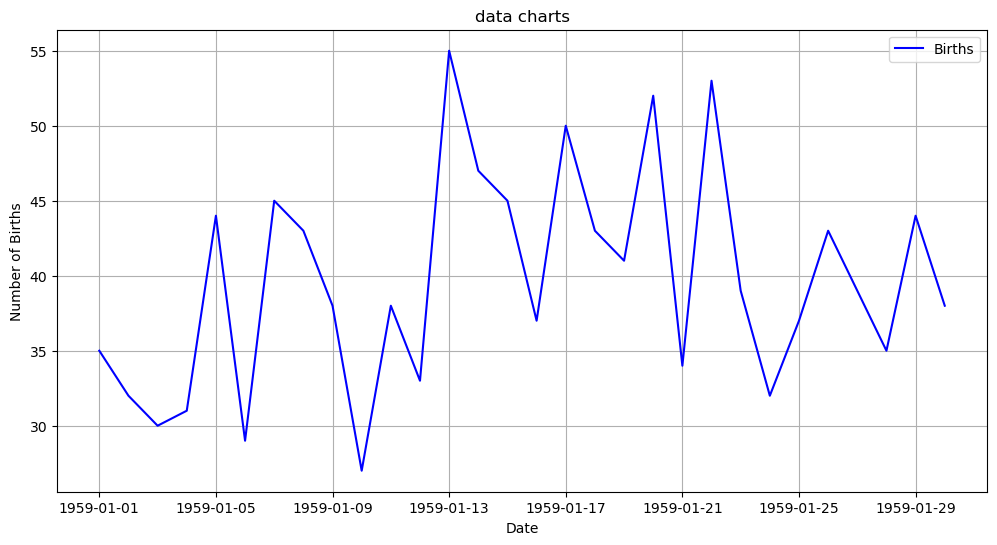

In [6]:
# plotting line chart for data
plt.figure(figsize=(12, 6))
plt.plot(data.index[:30], data['Births'].iloc[:30], label='Births', color='blue')
plt.title('data charts')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.grid()
plt.show()

In [7]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    """
    Create input sequences and corresponding targets for time series prediction. This function is handling only 1 column of data which is in array format.
    """
    X, y = [], []

    
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    
    return np.array(X), np.array(y)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_target.fit(data[['Births']])

X_np, y_np = create_sequences(scaled_data, 1)
train_size = int(len(X_np) * 0.8)

In [9]:
def data_function(n_steps=10, batch_size=32):
    """
    Function to return the train and test data loaders.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    scaler_target = MinMaxScaler(feature_range=(0, 1))
    scaler_target.fit(data[['Births']])

    X_np, y_np = create_sequences(scaled_data, n_steps)
    train_size = int(len(X_np) * 0.8)
    X_train_np, X_test_np = X_np[:train_size], X_np[train_size:]
    y_train_np, y_test_np = y_np[:train_size], y_np[train_size:]
    print(f"\nShape of X_train: {X_train_np.shape}")
    print(f"Shape of y_train: {y_train_np.shape}")
    print(f"Shape of X_test: {X_test_np.shape}")
    print(f"Shape of y_test: {y_test_np.shape}")

    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1) # Add feature dimension for target
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1) # Add feature dimension for target

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # Shuffle=False for time series
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Shuffle=False for time series
    
    return X_train_tensor, train_loader, test_loader, scaler_target, y_test_tensor

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        hidden_units = [int(u) for u in str(hidden_size).split('-')]
        self.num_layers = len(hidden_units)
        self.hidden_units = hidden_units
        current_dim = input_size
        self.lstm_layers = nn.ModuleList()
        for units in hidden_units:
            self.lstm_layers.append(
                nn.LSTM(current_dim, units, num_layers, batch_first=True, dropout=dropout_rate)
            )
            current_dim = units  # Update current_dim for the next LSTM layer
        
        # Fully connected layer for output
        self.fc1 = nn.Linear(hidden_units[-1], hidden_units[-1]//2)
        self.selu = nn.SELU()
        self.fc2 = nn.Linear(hidden_units[-1]//2, 1)
        self._reinitialize_weights()

    def _reinitialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.LSTM):
                for name, param in layer.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_uniform_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)
            elif isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)


    def forward(self, x):
        out = x
        for lstm in self.lstm_layers:
            out, _ = lstm(out)
        out = self.fc1(out[:, -1, :])  # Use the last time step's output
        out = self.selu(out)
        out = self.fc2(out)
        return out

In [11]:
def objective(trial):
    # Suggest hyperparameters
    hidden_size = trial.suggest_categorical("hidden_size", ["64-32", "128-64-32", "108-64-32", "1", "4-2", "16-8-4"])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # hidden_size = "64-32"
    # dropout_rate = 0.27
    # learning_rate = 0.009
    # batch_size = 32
    # n_steps = trial.suggest_int("n_steps", 1, 20)  # Number of past steps to consider
    num_layers = len(hidden_size.split('-'))
    n_steps = 1

    X_train_tensor, train_loader, test_loader, scaler_target, y_test_tensor = data_function(n_steps, batch_size)

    # Model setup
    input_size = X_train_tensor.shape[2]
    # num_layers = len(hidden_size.split('-'))
    model = LSTMModel(input_size, hidden_size, num_layers, dropout_rate).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Train for a few epochs (e.g., 20 for speed)
    for epoch in range(20):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(test_loader.dataset)

    # Report intermediate objective value
    trial.report(val_loss, epoch)

    # Prune trial if not improving
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return val_loss

# Run Optuna study
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=49)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-07 21:59:16,336] A new study created in memory with name: no-name-45b0ca5b-92fb-495c-b09a-e1de8f13766c
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:19,651] Trial 0 finished with value: 0.01678113057597043 and parameters: {'hidden_size': '16-8-4', 'dropout_rate': 0.15910027438764832, 'learning_rate': 0.0045772062409058225, 'batch_size': 32}. Best is trial 0 with value: 0.01678113057597043.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:20,871] Trial 1 finished with value: 0.016752849753997098 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.14304496081305246, 'learning_rate': 0.0014796548067376014, 'batch_size': 32}. Best is trial 1 with value: 0.016752849753997098.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:21,620] Trial 2 finished with value: 0.016622975596213993 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.30022147849875547, 'learning_rate': 0.0029550817432977185, 'batch_size': 64}. Best is trial 2 with value: 0.016622975596213993.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:24,898] Trial 3 finished with value: 0.016855558610125762 and parameters: {'hidden_size': '108-64-32', 'dropout_rate': 0.3721598004057507, 'learning_rate': 0.00041108954392057113, 'batch_size': 32}. Best is trial 2 with value: 0.016622975596213993.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:31,170] Trial 4 finished with value: 0.016843973084875983 and parameters: {'hidden_size': '108-64-32', 'dropout_rate': 0.25998388594489663, 'learning_rate': 0.0028544942189787886, 'batch_size': 16}. Best is trial 2 with value: 0.016622975596213993.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:34,726] Trial 5 finished with value: 0.016727723410888892 and parameters: {'hidden_size': '108-64-32', 'dropout_rate': 0.41248676844248644, 'learning_rate': 0.008730143752754334, 'batch_size': 32}. Best is trial 2 with value: 0.016622975596213993.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\aravi\anaconda3\envs\credit_risk_env\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32100973183357817 and num_layers=1
  warnings.warn(
c:\Users\aravi\anaconda3\envs\credit_risk_env\Lib\site-packages\torch\nn\init.py:511: UserWar


Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:35,289] Trial 6 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:36,142] Trial 7 finished with value: 0.016684489375720285 and parameters: {'hidden_size': '16-8-4', 'dropout_rate': 0.44730760041474404, 'learning_rate': 0.001313755523128044, 'batch_size': 64}. Best is trial 2 with value: 0.016622975596213993.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:37,407] Trial 8 finished with value: 0.016641528537012125 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.309359401383581, 'learning_rate': 0.0033729133701099014, 'batch_size': 32}. Best is trial 2 with value: 0.016622975596213993.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:40,775] Trial 9 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:41,256] Trial 10 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:42,039] Trial 11 finished with value: 0.016674123194119702 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.32473978555990696, 'learning_rate': 0.003261784943833786, 'batch_size': 64}. Best is trial 2 with value: 0.016622975596213993.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:42,833] Trial 12 finished with value: 0.01649033308845677 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.2375555647726575, 'learning_rate': 0.007181992079423932, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:44,798] Trial 13 finished with value: 0.016654593436277076 and parameters: {'hidden_size': '128-64-32', 'dropout_rate': 0.22971341284474542, 'learning_rate': 0.007779682644954514, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:45,629] Trial 14 finished with value: 0.016602123947176216 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.10196894446020058, 'learning_rate': 0.0018970472134745588, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:46,441] Trial 15 finished with value: 0.016668561182609978 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.10508804878012953, 'learning_rate': 0.0018088190498858246, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:48,434] Trial 16 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\aravi\anaconda3\envs\credit_risk_env\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10853878530298883 and num_layers=1
  warnings.warn(
c:\Users\aravi\anaconda3\envs\credit_risk_env\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
[I 2025-07-07 21:59:48,629] Trial 17 pruned. 



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:49,057] Trial 18 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:49,778] Trial 19 finished with value: 0.016610381486889435 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.18778554211863543, 'learning_rate': 0.009957610434297087, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:52,280] Trial 20 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:53,087] Trial 21 finished with value: 0.01660522374592415 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.1873849054004042, 'learning_rate': 0.009238293785171353, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:53,876] Trial 22 finished with value: 0.016627679591717785 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.1449732627150157, 'learning_rate': 0.006132361413854681, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:54,682] Trial 23 finished with value: 0.016626962779523576 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.1988241564272158, 'learning_rate': 0.005426938604309296, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:55,456] Trial 24 finished with value: 0.01661675844392548 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.2656832004479678, 'learning_rate': 0.006908543949783687, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:56,252] Trial 25 finished with value: 0.016598227854869137 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.16053256736631102, 'learning_rate': 0.0042140292421711965, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\aravi\anaconda3\envs\credit_risk_env\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12798380697937972 and num_layers=1
  warnings.warn(
c:\Users\aravi\anaconda3\envs\credit_risk_env\Lib\site-packages\torch\nn\init.py:511: UserWarni


Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)

Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:56,931] Trial 27 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 21:59:58,897] Trial 28 finished with value: 0.016636500364705306 and parameters: {'hidden_size': '128-64-32', 'dropout_rate': 0.12147176625545866, 'learning_rate': 0.0035168789523940926, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:01,521] Trial 29 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:03,299] Trial 30 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:04,078] Trial 31 finished with value: 0.016629623172626104 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.18180233514643163, 'learning_rate': 0.007545383809099868, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:04,925] Trial 32 finished with value: 0.016591385211030096 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.15595546257586404, 'learning_rate': 0.009646452811711186, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:05,728] Trial 33 finished with value: 0.01659952461311262 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.13887836953135435, 'learning_rate': 0.004398783874895006, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:06,563] Trial 34 finished with value: 0.016605705380031508 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.14320168754194015, 'learning_rate': 0.004632302874476524, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:08,045] Trial 35 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:08,848] Trial 36 finished with value: 0.016591619036785545 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.23220183898888355, 'learning_rate': 0.006274186644485457, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:10,855] Trial 37 finished with value: 0.01660952438944823 and parameters: {'hidden_size': '108-64-32', 'dropout_rate': 0.23478132173727076, 'learning_rate': 0.006169121748271114, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:14,530] Trial 38 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:17,191] Trial 39 finished with value: 0.016523275524377823 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.24481094613637713, 'learning_rate': 0.009935505075825603, 'batch_size': 16}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
c:\Users\aravi\anaconda3\envs\credit_risk_env\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2465098344954897 and num_layers=1
  warnings.warn(
c:\Users\aravi\anaconda3\envs\credit_risk_env\Lib\site-packages\torch\nn\init.py:511: UserWarning


Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:17,817] Trial 40 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:20,468] Trial 41 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:23,022] Trial 42 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:26,582] Trial 43 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:29,220] Trial 44 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:30,049] Trial 45 finished with value: 0.016604336897191936 and parameters: {'hidden_size': '64-32', 'dropout_rate': 0.17323598057933554, 'learning_rate': 0.005383761995917912, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:31,623] Trial 46 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:33,254] Trial 47 pruned. 
C:\Users\aravi\AppData\Local\Temp\ipykernel_38492\1059534505.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


[I 2025-07-07 22:00:35,266] Trial 48 finished with value: 0.01661764422099884 and parameters: {'hidden_size': '128-64-32', 'dropout_rate': 0.2221890710100019, 'learning_rate': 0.006698630843839889, 'batch_size': 64}. Best is trial 12 with value: 0.01649033308845677.


Best trial:
  Value: 0.01649033308845677
  Params: 
    hidden_size: 64-32
    dropout_rate: 0.2375555647726575
    learning_rate: 0.007181992079423932
    batch_size: 64


In [248]:
n_steps = 1
batch_size = 64
hidden_size = "32-16"
dropout_rate = 0.2
learning_rate = 0.004

X_train_tensor, train_loader, test_loader, scaler_target, y_test_tensor = data_function(n_steps, batch_size)
input_size = X_train_tensor.shape[2]  # Number of features per time step
num_layers = len(hidden_size.split('-'))  # Number of LSTM layers (automatically from string)



Shape of X_train: (291, 1, 1)
Shape of y_train: (291,)
Shape of X_test: (73, 1, 1)
Shape of y_test: (73,)


In [249]:
# Example hidden layer string

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers, dropout_rate)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)  # Adam optimizer with learning rate 0.0005

# Print model summary
print(model)
print(f"Model is using device: {device}")

LSTMModel(
  (lstm_layers): ModuleList(
    (0): LSTM(1, 32, num_layers=2, batch_first=True, dropout=0.2)
    (1): LSTM(32, 16, num_layers=2, batch_first=True, dropout=0.2)
  )
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (selu): SELU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
Model is using device: cpu


In [250]:
# Training the model
num_epochs = 70
print(f"\n--- Training the PyTorch LSTM Model for {num_epochs} epochs ---")



--- Training the PyTorch LSTM Model for 70 epochs ---


In [251]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad() # Zero the gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, targets) # Calculate loss
        loss.backward() # Backpropagation
        optimizer.step() # Update weights
        
        running_loss += loss.item() * inputs.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval() # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
    
    val_loss = val_running_loss / len(test_loader.dataset)
    val_losses.append(val_loss)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch [10/70], Train Loss: 0.0243, Validation Loss: 0.0165
Epoch [20/70], Train Loss: 0.0231, Validation Loss: 0.0167
Epoch [30/70], Train Loss: 0.0231, Validation Loss: 0.0167
Epoch [40/70], Train Loss: 0.0231, Validation Loss: 0.0166
Epoch [50/70], Train Loss: 0.0231, Validation Loss: 0.0165
Epoch [60/70], Train Loss: 0.0224, Validation Loss: 0.0157
Epoch [70/70], Train Loss: 0.0222, Validation Loss: 0.0153


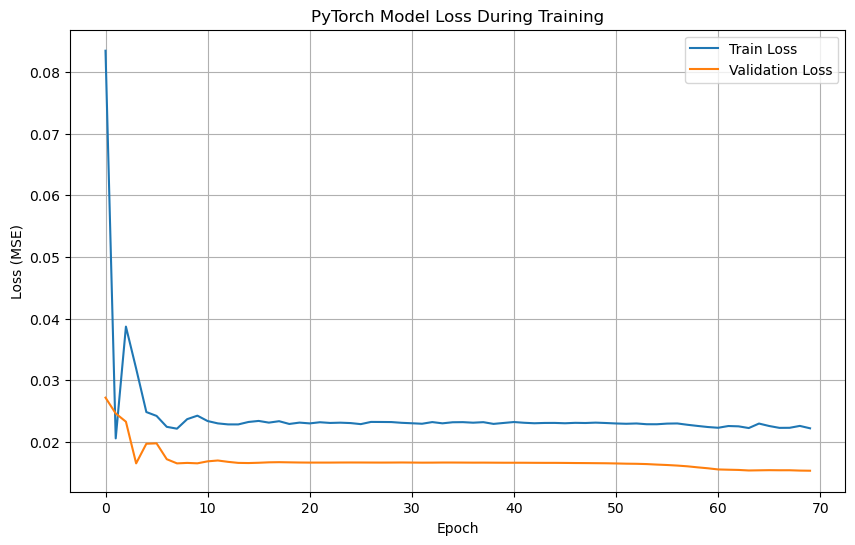

In [252]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('PyTorch Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [253]:
# Make predictions on the test set
print("\n--- Making Predictions on Test Data ---")
model.eval() # Set model to evaluation mode
y_pred_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred_scaled_list.extend(outputs.cpu().numpy())

y_pred_scaled = np.array(y_pred_scaled_list)


--- Making Predictions on Test Data ---


In [254]:
# Inverse transform the scaled predictions and actual test values
# y_test_tensor is (samples, 1), so its numpy version y_test_np is (samples,)
# We need to reshape y_pred_scaled to (samples, 1) to match the scaler_target's expected input.
y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_test_actual = scaler_target.inverse_transform(y_test_tensor.cpu().numpy())

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print(f"\n--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")



--- Model Evaluation ---
Mean Absolute Error (MAE): 4.914
Root Mean Squared Error (RMSE): 6.189


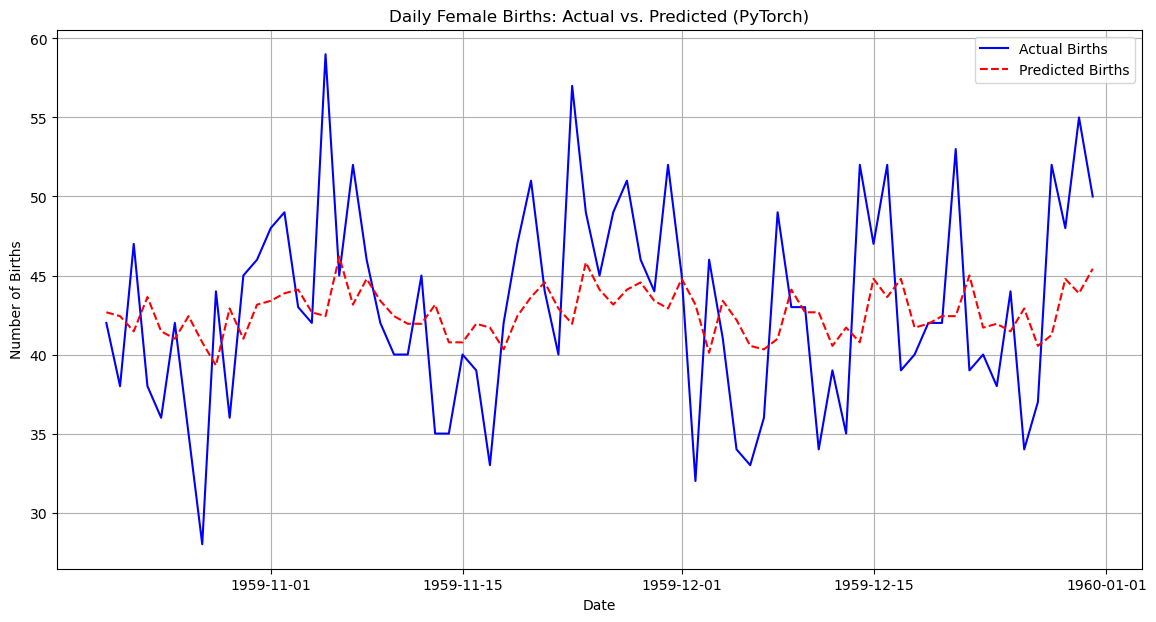

In [255]:
# Visualize actual vs. predicted values
plt.figure(figsize=(14, 7))
# Create a date range for the test set for plotting
# The original 'data' DataFrame index needs to be aligned with the test set.
# The test set starts after train_size + n_steps from the original data.
test_dates = data.index[train_size + n_steps:]
plt.plot(test_dates, y_test_actual, label='Actual Births', color='blue')
plt.plot(test_dates, y_pred, label='Predicted Births', color='red', linestyle='--')
plt.title('Daily Female Births: Actual vs. Predicted (PyTorch)')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.grid(True)
plt.show()

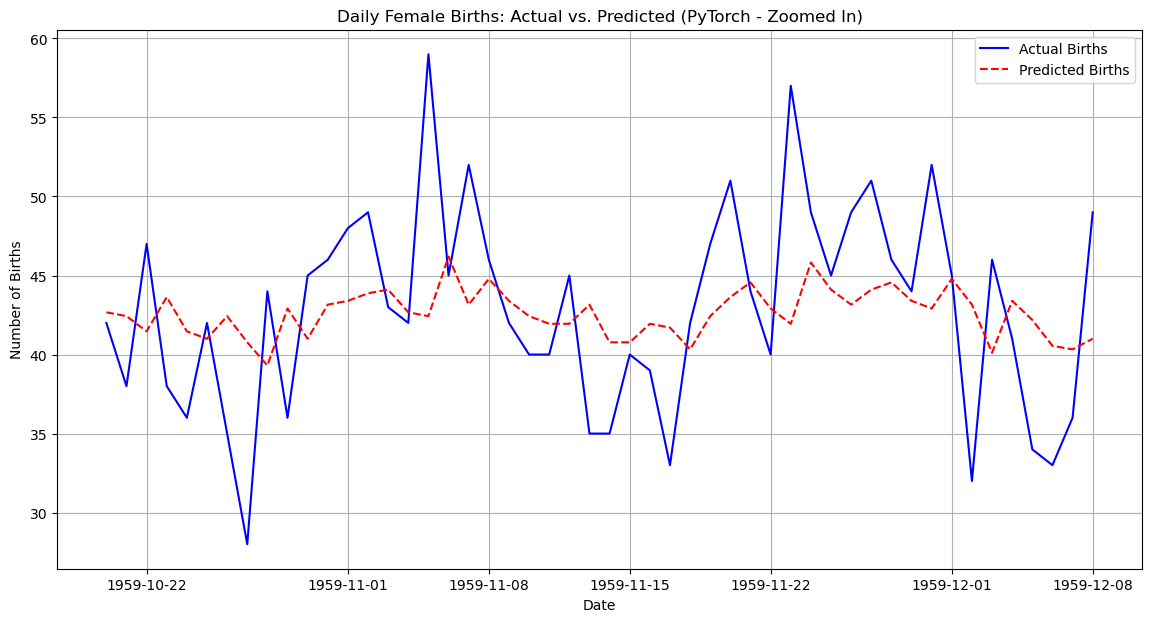

In [256]:
# Optionally, visualize a portion of the predictions for closer inspection
plt.figure(figsize=(14, 7))
plot_start_index = 0 # Adjust to zoom in on a specific part of the test set
plot_end_index = 50 # Plotting first 50 days of test predictions
plt.plot(test_dates[plot_start_index:plot_end_index], y_test_actual[plot_start_index:plot_end_index], label='Actual Births', color='blue')
plt.plot(test_dates[plot_start_index:plot_end_index], y_pred[plot_start_index:plot_end_index], label='Predicted Births', color='red', linestyle='--')
plt.title('Daily Female Births: Actual vs. Predicted (PyTorch - Zoomed In)')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.grid(True)
plt.show()